### Methylation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import (KNeighborsClassifier, NeighborhoodComponentsAnalysis)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from lifelines import CoxPHFitter

In [2]:
clin_file = 'clinical_final_extra.csv'
clin_data = pd.read_csv(clin_file)
clin_data.set_index('bcr_patient_barcode',inplace=True)
clin_data.sort_values(by=["bcr_patient_barcode"]);
# X = X.transpose()

In [3]:
meth_file = 'meth_final.csv'
meth_data = pd.read_csv(meth_file)
meth_data.set_index('Hybridization REF',inplace=True)
meth_data = meth_data.transpose()

In [4]:
#remove NAs
row1 = list(meth_data.iloc[1,:])

In [5]:
l_col=[]
for i in range(0,len(row1)):
    if pd.isnull(row1[i])==True:
        l_col.append(meth_data.columns[i])     
len(l_col)

0

In [6]:
meth_data=meth_data.drop(columns=l_col)
meth_data.shape

(530, 20115)

In [7]:
ll = list(meth_data.index)
for item in ll:
    tc = item[-3:]
    if tc=="-02":
        meth_data = meth_data.drop(str(item))

In [8]:
meth_data.shape

(516, 20115)

In [9]:
lll = list(meth_data.index)
ll_new = []
for item in lll:
    item = item[0:12]
    ll_new.append(item)
meth_data.index = ll_new

In [10]:
rem_row = list(set(meth_data.index)^set(clin_data.index))
len(rem_row)

3

In [11]:
rem_row

['TCGA-R8-A6YH', 'TCGA-CS-5390', 'TCGA-DU-7019']

In [12]:
for x in rem_row:
    if (x in clin_data.index):
        clin_data = clin_data.drop(x)
    if (x in meth_data.index):
        meth_data = meth_data.drop(x)

print(clin_data.shape)
print(meth_data.shape)

(513, 32)
(513, 20115)


In [18]:
clin_data.loc[meth_data.dropna().index,:].to_csv("processed_clinical_meth.csv")
meth_data.dropna().to_csv("processed_meth.csv")

In [19]:
meth_data.dropna().shape

(384, 20115)

In [14]:
y = clin_data.loc[:,["OS","OS.time"]]

In [15]:
y = y.loc[meth_data.dropna().index,:]
X = meth_data.dropna()

In [16]:
var = X.var()

In [17]:
X_new = X.loc[:,var[var>0.01].index]

In [18]:
my_data_transposed = X_new
my_data_transposed["Censor"] = y["OS"].values
my_data_transposed["Survival"] = y["OS.time"].values

In [ ]:
cph = CoxPHFitter(penalizer = 10)
cph.fit(my_data_transposed, duration_col='Survival', event_col='Censor', show_progress=True, step_size=0.4)
cph.print_summary()

Iteration 8: norm_delta = 6.20774, step_size = 0.0889, ll = -244.12786, newton_decrement = 211.87275, seconds_since_start = 508.8.9

In [39]:
random_state=0


In [53]:
accuracies_test_list = []
accuracies_train_list = []
for i in tqdm(range(2,30)):
    n_neighbors = i
    random_state = 0
    nca = make_pipeline(StandardScaler(),NeighborhoodComponentsAnalysis(n_components=32,random_state=random_state))
    te_score=[]
    tr_score=[]
    for j in range(0,5):
        X_test = X.iloc[int(j*len(y)/5):int((j+1)*len(y)/5),:]
        y_test = y[int(j*len(y)/5):int((j+1)*len(y)/5)]
        X_train = X.drop(X.index[range(int(j*len(y)/5),int((j+1)*len(y)/5))], axis=0)
        y_train = y.drop(X.index[range(int(j*len(y)/5),int((j+1)*len(y)/5))], axis=0)
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)
        nca.fit(X_train, y_train)
        # Fit a nearest neighbor classifier on the embedded training set
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(nca.transform(X_train), y_train)
        # Compute the nearest neighbor accuracy on the embedded test set
        te_score.append(knn.score(nca.transform(X_test), y_test))
        tr_score.append(knn.score(nca.transform(X_train), y_train))
    accuracies_test_list.append(np.mean(te_score))
    accuracies_train_list.append(np.mean(tr_score))

0.7681476418318522
0.7877575193536106


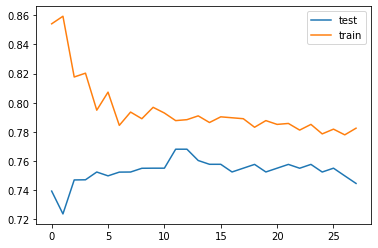

In [52]:
print(accuracies_test_list[np.argmax(accuracies_test_list)])
print(accuracies_train_list[np.argmax(accuracies_test_list)])
plt.plot(accuracies_test_list, label="test")
plt.plot(accuracies_train_list, label="train")
plt.legend()
plt.show()

0.7708133971291866
0.7903570370997081


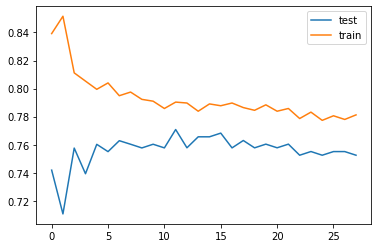

In [54]:
print(accuracies_test_list[np.argmax(accuracies_test_list)])
print(accuracies_train_list[np.argmax(accuracies_test_list)])
plt.plot(accuracies_test_list, label="test")
plt.plot(accuracies_train_list, label="train")
plt.legend()
plt.show()

In [ ]:
# Embed the data set in 2 dimensions using the fitted model
X_embedded = nca.transform(X)